Importing Data from files

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob


def get_measurement(file_dir):

    # Specify the directory containing the .fit files (replace with your actual path)
    file_paths = sorted(glob.glob(file_dir + "*.fit"))

    # Initialize lists to store combined data and time axis
    combined_data = []
    time_offset = 0  # To manage time axis across multiple files
    time_axes = []  # To concatenate time axes properly

    # Loop through each .fit file
    for file_path in file_paths:
        hdul = fits.open(file_path)
        
        # Access data (assuming it's a 2D array with shape [frequency, time])
        data = hdul[0].data
        
        # Extract time axis (dummy axis if not provided in the header)
        time_axis = np.arange(data.shape[1]) + time_offset
        time_axes.append(time_axis)
        
        # Append data to the combined list
        combined_data.append(data)
        
        # Update time offset for the next file
        time_offset += data.shape[1]
        
        # Close the file
        hdul.close()

    # Concatenate all data and time axes
    combined_data = np.hstack(combined_data)  # Combine along the time axis
    time_axis_combined = np.hstack(time_axes)  # Combined time axis
    freq_axis = np.arange(combined_data.shape[0])  # Dummy frequency axis

    return time_axis_combined, freq_axis, combined_data






Functions for Data analysis

In [2]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

def savgol_smooth(data, window_length=5, poly_order=2):
    """
    Smooths a 2D array along the first axis using the Savitzky-Golay filter.

    Parameters:
        data (ndarray): 2D array to be smoothed.
        window_length (int): Length of the filter window (must be odd).
        poly_order (int): Polynomial order to fit.

    Returns:
        ndarray: Smoothed 2D array.
    """
    smoothed_data = np.apply_along_axis(
        lambda x: savgol_filter(x, window_length=window_length, polyorder=poly_order),
        axis=0,
        arr=data
    )
    return smoothed_data



def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B


def theoretical_fit(x, S, V, omega, delta):
    return S*(1+V*np.sin(omega*x+delta))




def get_V_Bl_fromOneChannel(time, data, freq=0, measurement=0,guess=[1, 0.035, 0.0043, 5.6], printbool=False, delta=0, coeff="None"):
    """
    takes one channel of a measurement and returns  
    visibility, effective baseline, gaussian fit parameters and their stds
    """
    try:

        # Apply smoothing
        smoothed_data = savgol_smooth(data, window_length=500, poly_order=3)



        # Fitting a Gaussian + linear
        lower_bounds=[-np.inf,-np.inf,-np.inf,-0.0005, -np.inf]
        upper_bounds=[np.inf,np.inf,np.inf,0.0005, np.inf]
        gaussian_params, pcov = curve_fit(gaussian, time, smoothed_data, p0=[17.5, 5720, 4640, 0, 140],bounds=(lower_bounds, upper_bounds))
        I, mu, sigma, A, B = gaussian_params

        params_stds = np.sqrt(np.diag(pcov))
        params = gaussian_params


        #error propagation through variation
        if (coeff =="I"):
            I +=delta
        if (coeff =="mu"):
            mu +=delta
        if (coeff =="sigma"):
            sigma +=delta
        if (coeff =="A"):
            A +=delta
        if (coeff =="B"):
            B +=delta


        # subtract and divide the data
        fitted_gaussian = gaussian(time, I, mu, sigma, 0, 0)
        linear = A*time + B            
        sd_minus_linear = smoothed_data - linear
        data_theo = sd_minus_linear/fitted_gaussian




        # Fit the theoretical fit
        t_min = int(max(np.rint(mu-abs(sigma)),0))
        t_max = int(min(np.rint(mu+abs(sigma)),len(time)-1))

        fit_params, pcov = curve_fit(theoretical_fit, time[t_min:t_max], data_theo[t_min:t_max], p0=guess)
        S, V, omega, delta = fit_params


        if printbool:
            print(f"Measurement {measurement}, Channel {freq}")

            #get real time and frequency
            real_time = time * 0.25
            frequency = 2701.5 + (2200 - 2701.5)*freq/199
            
            # Generate fitted values for plotting
            fitted_gaussian_linear = gaussian(time, I, mu, sigma, A, B)
            fitted = theoretical_fit(time, S, V, omega, delta)
            data_theo_unsmoothed = (data-linear)/fitted_gaussian


            # Gaussian plot
            plt.scatter(real_time, data, label="Data", color="green", marker="o", s=5, alpha=0.7)
            plt.plot(real_time, fitted_gaussian_linear, label=f"Gaussian+linear fit: I={I:.2f}, μ={mu:.2f}, σ={sigma:.2f}, A={A:.5f}, B={B:.2f}", color="purple")
            plt.title(f"Gaussian + Linear Fit; meas {measurement+1}, Channel {frequency:.1f} MHz")
            plt.xlabel("Time [s]")
            plt.ylabel("Data [max 255]")
            plt.legend()
            plt.tight_layout()
            plt.savefig("example_gauss.pdf")
            plt.show()

            # Theoretical fit plot
            plt.scatter(real_time[t_min:t_max], data_theo_unsmoothed[t_min:t_max], label="(Data-Linear)/Gaussian", color="green", marker="o", s=5, alpha=0.7)
            plt.plot(real_time[t_min:t_max], fitted[t_min:t_max], label=f"Fit S={S:.2f}, V={V:.2f}, omega={omega:.4f}, delta={delta:.2f}, B={B:.2f}", color="purple")
            plt.title(f"Fit; meas {measurement+1}, Channel {frequency:.1f} MHz")
            plt.xlabel("Time [s]")
            plt.ylabel("Data [max 255]")
            plt.legend()
            plt.tight_layout()
            plt.savefig("example_theofit.pdf")
            plt.show()



        #compute return values
        dec = np.cos(2*np.pi/360 *22.1)  #declination of the sun January 10th
        std = np.sum(np.sqrt(np.diag(pcov))) #general quality of fit
        
        
        #old: 0.02
        if (std < 0.02):
            print(f"accepted measurement {measurement}, channel {freq}")
  
            return abs(V), abs(omega/(2*np.pi)**2 * 24*60*60*4/dec), params, params_stds
        
        else:
            print(f"not accepted measurement {measurement}, channel {freq}")
            return 0,0, params, params_stds
        

    except Exception as e:
        # Log the exception for debugging purposes if needed
        print(f"Exception at measurement {measurement}, channel {freq}: {e}")
        return 0,0, np.zeros(5), np.zeros(5)







Fitting the Data

In [3]:

# Directories for measurements
file_dirs = [
    "sun_meas_25/meas_1/", #good 
    "sun_meas_25/meas_2/", #good
    "sun_meas_25/meas_3/", #good
    #"sun_meas_25/meas_4/",#sunset
    #"sun_meas_25/meas_5/",#clouds
    "sun_meas_25/meas_6/", #good
    "sun_meas_25/meas_7/", #very early -> only to the left
    "sun_meas_25/meas_8/",
    "sun_meas_25/meas_9/"
]
guesses = [[1, 0.035, 0.0043, 5.6], 
           [1, 0.035, 0.0047, 5.6],
           [1, 0.035, 0.0046, 5.6],
           #[1, 0.035, 0.0043, 5.6],
           #[1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0055, 5.6]]

# Load measurements
measurements = [get_measurement(file_dir) for file_dir in file_dirs]
# Each element of measurements is (time, freq, data)

#specific file just to plot and see:
#test = 0
#test_freq = 50
#(time, freq, data) = measurements[test]
#v, b,_,_,_,_ = get_V_Bl_fromOneChannel(time, data[test_freq], test_freq, test, guesses[test], printbool=True, delta=0.1, coeff="I")

#all files for analysis:

interesting_frequencies = np.concatenate((np.arange(10,50),np.arange(150,180)))
number_of_int_freq = len(interesting_frequencies)


def get_results_with_param_distribution():
    # Prepare storage for results
    results = np.empty((len(file_dirs),2,number_of_int_freq), dtype=float)
    results_params = np.empty((len(file_dirs),5,number_of_int_freq), dtype=float)
    results_params_fit_stds = np.empty((len(file_dirs), 5, number_of_int_freq), dtype=float)
    

    
    for file_index, (time, freq, data) in enumerate(measurements):
        visibilities = np.empty(number_of_int_freq, dtype=float)
        Bl = np.empty(number_of_int_freq, dtype=float)

        params = np.empty((5, number_of_int_freq), dtype=float)
        params_fit_stds = np.empty((5, number_of_int_freq), dtype=float)

        
        for i, freq in enumerate(interesting_frequencies):
            #actual fit
            visibilities[i], Bl[i], params[:,i], params_fit_stds[:,i] = get_V_Bl_fromOneChannel(time, data[i], freq, file_index+1, guesses[file_index], printbool=False)
            
        results[file_index,0,:] = visibilities
        results[file_index,1,:] = Bl

        results_params[file_index] =params
        results_params_fit_stds[file_index] = params_fit_stds


    return results, results_params, results_params_fit_stds

results, results_params, results_params_fit_stds = get_results_with_param_distribution()




accepted measurement 1, channel 10
accepted measurement 1, channel 11
accepted measurement 1, channel 12
accepted measurement 1, channel 13
accepted measurement 1, channel 14
accepted measurement 1, channel 15
accepted measurement 1, channel 16
accepted measurement 1, channel 17
accepted measurement 1, channel 18
accepted measurement 1, channel 19
accepted measurement 1, channel 20
accepted measurement 1, channel 21
accepted measurement 1, channel 22
accepted measurement 1, channel 23
accepted measurement 1, channel 24
accepted measurement 1, channel 25
accepted measurement 1, channel 26
accepted measurement 1, channel 27
not accepted measurement 1, channel 28
accepted measurement 1, channel 29
not accepted measurement 1, channel 30
accepted measurement 1, channel 31
accepted measurement 1, channel 32
accepted measurement 1, channel 33
accepted measurement 1, channel 34
accepted measurement 1, channel 35
accepted measurement 1, channel 36
accepted measurement 1, channel 37
accepted mea

Sensitivity Analysis

In [4]:
"""computing the parameter contributions to the uncertainty"""


number_of_runs = 20
file_index = 6

params = ["I", "mu", "sigma", "A", "B"]

interesting_frequencies_propag = np.concatenate((np.arange(20,30),np.arange(150,160)))
#interesting_frequencies takes about half an hour!


#for all parameters their distribution over all frequencies is taken
params_distributions = np.std(results_params[file_index,:,:], axis=1)
print(params_distributions)

def get_sigma_contribution_i(param):
    param_index = params.index(param)

    """"deviating params according to per file distribution"""
    param_deviations = np.random.normal(0, params_distributions[param_index], number_of_runs)

    visibilities_deviations = np.empty((len(interesting_frequencies_propag),number_of_runs), dtype=float)
    Bl_deviations = np.empty((len(interesting_frequencies_propag), number_of_runs), dtype=float)

    time, __, data = measurements[file_index]
    
    for i, freq in enumerate(interesting_frequencies_propag):

        for j, param_deviation in enumerate(param_deviations):
            vis_with_dev, Bl_with_dev, __, __ = get_V_Bl_fromOneChannel(time, data[i], freq, file_index+1, guesses[file_index], printbool=False, delta=param_deviation, coeff=param)

            visibilities_deviations[i,j] = np.abs(vis_with_dev - results[file_index][0][i])
            Bl_deviations[i,j] = np.abs(Bl_with_dev - results[file_index][1][i])
    return np.std(visibilities_deviations), np.std(Bl_deviations)




from concurrent.futures import ThreadPoolExecutor


with ThreadPoolExecutor() as executor:
    sigmas = list(executor.map(get_sigma_contribution_i, params))

sigmas = np.array(sigmas)




[1.20233821e+00 9.95645317e+01 9.21149128e+01 2.89656543e-05
 2.57094113e+01]
accepted measurement 7, channel 20accepted measurement 7, channel 20

accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
not accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
not accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20accepted measurement 7, channel 20

accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
not accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20
accepted measurement 7, channel 20


saving all data in a file so the computations do not need to be redone

In [5]:
import dill
import types
import sqlite3

# Function to check if an object is picklable
def is_picklable(obj):
    try:
        dill.dumps(obj)  # Try serializing
        return True
    except (TypeError, AttributeError):
        return False

# Save all picklable variables, excluding modules and sqlite3 connections
picklable_vars = {
    k: v
    for k, v in globals().items()
    if not k.startswith("__")
    and not isinstance(v, types.ModuleType)
    and not isinstance(v, sqlite3.Connection)  # Exclude database connections
    and is_picklable(v)  # Final check for picklability
}

# Save variables
with open("processed_data.pkl", "wb") as f:
    dill.dump(picklable_vars, f)

print("Variables saved successfully, excluding unpickleable objects!")



Variables saved successfully, excluding unpickleable objects!


Start again from here

In [6]:
import dill
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import os

if os.stat("processed_data.pkl").st_size == 0:
    print("⚠ The file is empty!")


# Load all variables
with open("processed_data.pkl", "rb") as f:
    globals().update(dill.load(f))

print("Variables loaded successfully!")




Variables loaded successfully!


In [21]:
"""printing some results"""

mean =np.mean(results_params[6,:,:], axis=1)
std =np.std(results_params[6,:,:], axis=1)

print(["{:.5f}".format(x) for x in mean])
print(["{:.5f}".format(x) for x in std])
print(["{:.5f}".format(x) for x in std/mean])


['16.40047', '11370.43811', '3961.15288', '0.00005', '128.29214']
['1.20234', '99.56453', '92.11491', '0.00003', '25.70941']
['0.07331', '0.00876', '0.02325', '0.60334', '0.20040']


In [8]:
"""error propagation"""
#using the filewise distribution of the params
#for the intensity I, the std of the fit is used, since it depends on the frequency

sigma_visibility = np.sqrt(np.sum(sigmas[:,0]**2))
sigma_Bl = np.sqrt(np.sum(sigmas[:,1]**2))
print(sigma_visibility)
print(sigma_Bl)



0.19040940493102437
16.08064848873104


Plotting

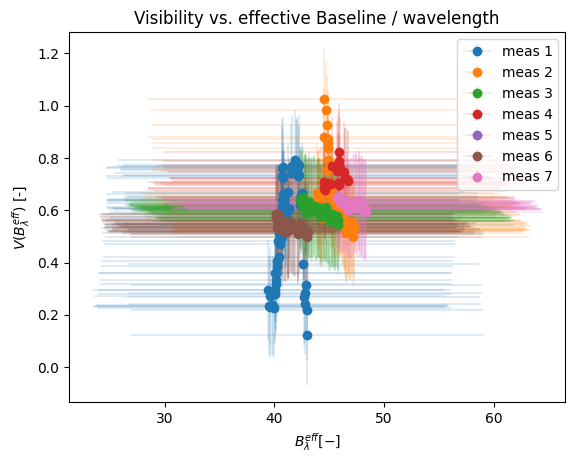

In [10]:
#for all pairs of V and Bl of all files, the same std is taken
useful_B = []
useful_V = []
useful_B_err = []
useful_V_err = []

for index, (visibilities, Bl) in enumerate(results):
    valid_indices =[(v, b) for v, b in zip(visibilities, Bl) if not (abs(v) <1e-2 or abs(v)>2 or abs(b)>50 > 2 or abs(b)<5)]
    vs, bs = zip(*valid_indices) if valid_indices else ([],[])
    useful_B.append(bs)
    useful_V.append(vs)
    useful_B_err.append(sigma_Bl)
    useful_V_err.append(sigma_visibility)
    plt.errorbar(bs, vs, xerr=sigma_Bl, yerr=sigma_visibility,fmt='o', lw = 0.2,linestyle='--', label=f"meas {index+1}")
plt.title("Visibility vs. effective Baseline / wavelength")
plt.ylabel("$V(B_{\lambda}^{eff})$ [-]")
plt.xlabel("$B_{\lambda}^{eff} [-]$")
plt.legend()
#plt.savefig("visibility_vs_effbase.png", dpi=150)
plt.show()






Fitting the Sinc function, error prop, and plotting

In [11]:
def sinc_func(Bl, alpha):
    return abs(np.sinc(Bl * alpha))
    
useful_B_array = np.concatenate(useful_B, axis=0 )
useful_V_array = np.concatenate(useful_V, axis=0 )

sun_radius = 696340 #km
sun_distance = 147.11e6 #km
sun_angle = 2*sun_radius/sun_distance

print("for the result to lie within 1 to 2 times the actual value the range for alpha is:")
print(sun_angle)
print(2*sun_angle)

lower_bounds = 0.001  # Lower bounds for S and alpha
upper_bounds = 0.02      # Upper bounds for S and alpha


fit_params, pcov = curve_fit(sinc_func, useful_B_array, useful_V_array, p0=[0.004], bounds=(lower_bounds, upper_bounds))
alpha, = fit_params


print(f"ratio {alpha/sun_angle}")



for the result to lie within 1 to 2 times the actual value the range for alpha is:
0.00946692950853103
0.01893385901706206
ratio 1.278926744906936


In [ ]:
"""monte carlo error prop"""

number_of_runs = 10000
deva = []

for _ in range(number_of_runs):
    x_pertubation = np.random.normal(0, sigma_Bl, size=len(useful_B_array)) 
    y_pertubation = np.random.normal(0, sigma_visibility, size=len(useful_V_array))

    x_perturbed = useful_B_array +  x_pertubation
    y_perturbed = useful_V_array + y_pertubation

    popt, _ = curve_fit(sinc_func, x_perturbed, y_perturbed,bounds=(0.001,0.02))
    deva.append(abs(popt[0]-alpha))
sigma_deva = np.std(deva)
sigma_alpha_monte_carlo = sigma_deva
sigma_radius_ratio = sigma_alpha_monte_carlo/sun_angle

print(f"radio: {alpha/sun_angle} pm {sigma_radius_ratio}")

radio: 1.278926744906936 pm 0.0307935116541463


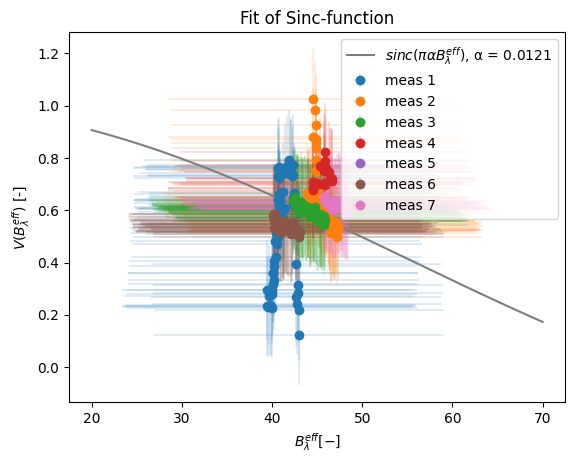

In [14]:
"""plotting the sinc fit"""

B_fit = np.linspace(20,70, 1000)
fitted_sinc = sinc_func(B_fit, alpha)

for i, (bs, vs, be, ve) in enumerate(zip(useful_B, useful_V, useful_B_err, useful_V_err)):

    plt.errorbar(bs, vs,xerr=be, yerr=ve,  lw =0.2, label=f"meas {i+1}",fmt="o")

plt.plot(B_fit, fitted_sinc, label = f"$sinc(\pi α B_{{\lambda}}^{{eff}})$, α = {alpha:.4f}")


plt.title("Fit of Sinc-function")
plt.ylabel("$V(B_{\lambda}^{eff})$ [-]")
plt.xlabel("$B_{\lambda}^{eff} [-]$")
plt.legend()
plt.savefig("fit.pdf",dpi=150)

In [ ]:
"""print the parameters for measurement 7"""
print(results_params[6,:,0])

[1.64004732e+01 1.13704381e+04 3.96115288e+03 4.80089294e-05
 1.28292137e+02]
